In [1]:
%matplotlib inline 
#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [2]:
import random            as random
import numpy             as np
import pandas            as pd
#import tables            as tb
import matplotlib.pyplot as plt
import os 

In [3]:
import xyimg.dataprep as dp
import xyimg.cnn      as cnn

## Definitions

In [4]:
path = os.environ['LPRDATADIR']+'shots/'

pressure  = '5bar'
hit_width = 0 # mm
sigma     = 0 # mm
width     = 10  #mm
ifile     = path + dp.filename_godata(pressure, 'shuffle', hit_width, sigma, width)

#igodata = dp.godata_load(ifile)

#cnn.test(ifile)

## RUN CNN

In [5]:
def _cnn_name(cnn_name, expansion, nepochs):
    return cnn_name + 'f'+str(expansion)+'e'+str(nepochs)

def run(ifile, labels, cnn_name = 'kcnn', expansion = 10, nepochs = 20):
    #labels     = ['esum'] if ifile.find('xymm') > 0 else ['xy_E_sum']
    cnn_name = _cnn_name(cnn_name, expansion, nepochs)
    ofile = cnn.cnn_filename(ifile, labels, cnn_name)
    idata = cnn.GoDataset(ifile, labels)
    config  = {'loss_function' : 'MSELoss'}
    _, depth, width, _ = idata.x
    kernel = 3
    kcnn = cnn.KCNN(depth, width, expansion = expansion, kernel = kernel)
    rcnn = cnn.run(idata, NNType = cnn.KCNN, ofilename = ofile, nepochs = nepochs, config = config)
    return rcnn 

In [53]:
def img_stats(xii):
    nn, sum, mean, std = len(xii), np.sum(xii), np.mean(xii), np.std(xii)
    return nn, sum, mean, std

def plot_dset(dset, index):
    yi, fileid, evt = int(dset.y[index]), int(dset.id[index][0]), int(dset.id[index][1])
    print('index ', index, 'target ', yi, ', id', fileid, evt)
    xi = dset.x[index]
    ndepth = xi.shape[0]
    plt.figure()
    for i in range(ndepth):
        plt.subplot(1, ndepth, i+1)
        xii = xi[i]
        nn, sum, mean, std = img_stats(xii[xii > 0.])
        print('length ', nn, ', sum ', sum, ', mean ', mean, ', std', std)
        plt.imshow(xi[i])
    return fileid, evt


def get_event(dset, fileid, evt):
    id = dset.id
    #id = np.squeeze(data.id, axis = 2)
    ii = [i for i in range(id.shape[0]) if ((id[i][0] == fileid) & (id[i][1] == evt))]
    print('found ', len(ii))
    kevt = ii[0]
    print('file, event : ', id[kevt])
    return kevt


In [20]:
ipath  = os.environ['LPRDATADIR']
ifile  = ipath + 'shots/'+ dp.filename_godata(pressure, 'shuffle', hit_width, sigma, width)
labels = ['xy_E_sum']

In [23]:
godata = dp.godata_load(ifile)

y   1
id  [205  47]


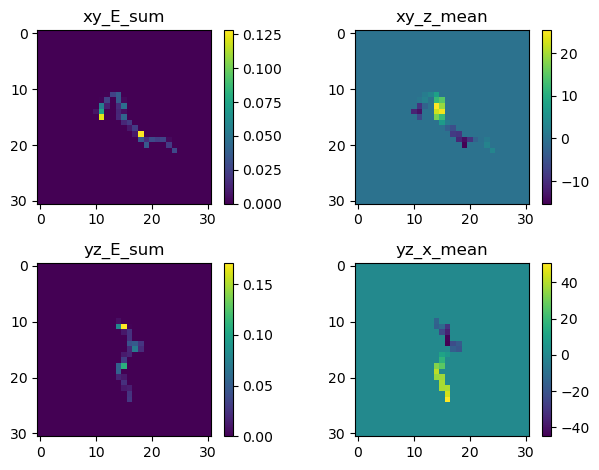

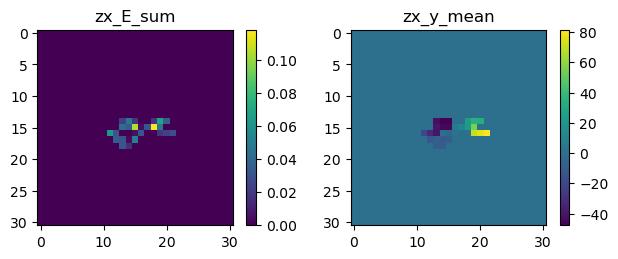

<Figure size 640x480 with 0 Axes>

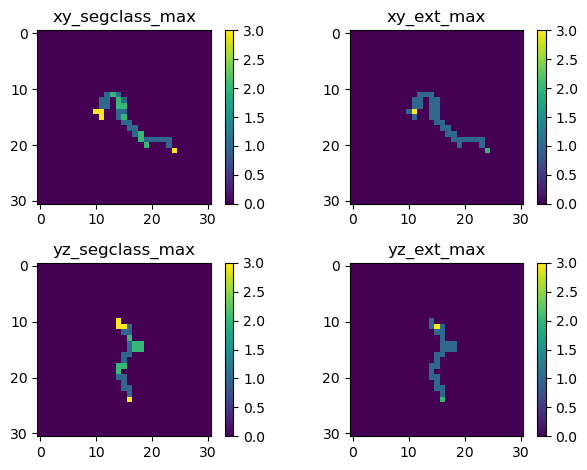

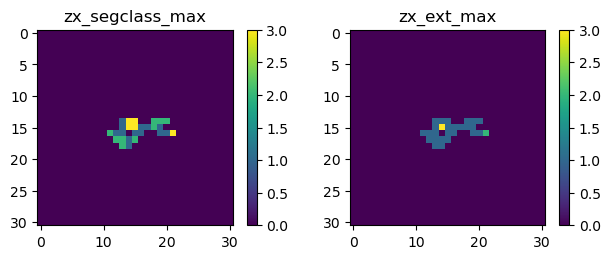

<Figure size 640x480 with 0 Axes>

In [30]:
i = 3
dp.plot_godata(godata, i)

In [131]:
idata = cnn.GoDataset(ifile, labels)

index  0 target  0 , id 1922 5
length  41 , sum  0.9209129763370794 , mean  0.022461292105782422 , std 0.021997425075316827
index  1 target  0 , id 37 24
length  21 , sum  1.0 , mean  0.047619047619047616 , std 0.041210981745861255
index  2 target  1 , id 94 212
length  31 , sum  1.0 , mean  0.03225806451612903 , std 0.029606162790617535
index  3 target  1 , id 205 47
length  33 , sum  0.9581906182839853 , mean  0.02903607934193895 , std 0.029252237301351545


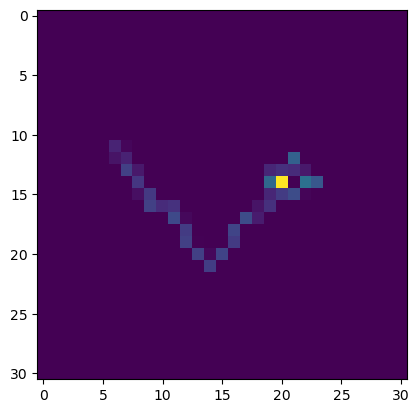

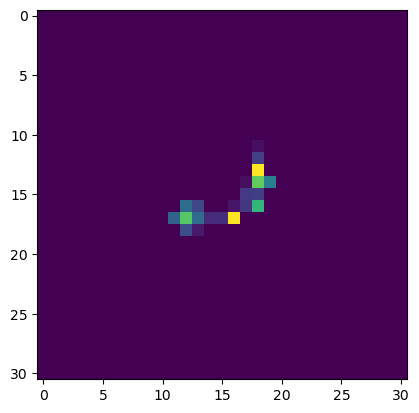

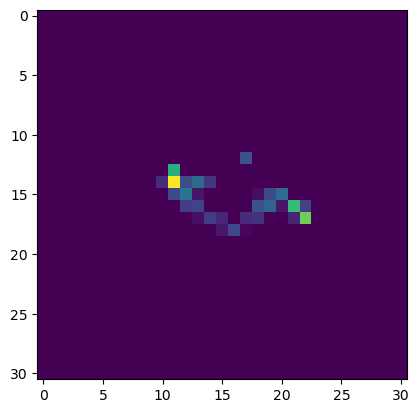

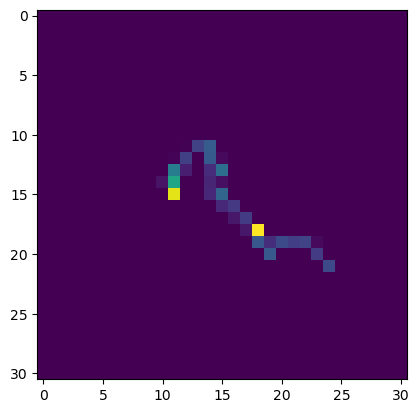

In [132]:
for i in range(4): plot_dset(idata, i)

In [223]:
size, depth, width, _ = idata.x.shape
expansion =   4
nepochs   =   5
kernel    =   3
kcnn  = cnn.KCNN(depth, width, expansion = expansion, kernel = kernel)

In [224]:
cnn_name = 'test_kcnn'
cnn_name = cnn._cnn_name(cnn_name, expansion, nepochs)
ofile = cnn.cnn_filename(ifile, labels, cnn_name)
print(ofile)


/scratch/next/data/NEXT100/pressure_topology/shots/5bar_shuffle_h0mm_s0mm_w10mm_test_kcnn_f4e5_xy_E_sum.npz


In [230]:
config  = {'loss_function' : 'BCELoss'}
box  = cnn.run(idata, kcnn, ofilename = ofile, nepochs = nepochs, config = config)

Dataset : 
   labels   : ['xy_E_sum']
   x shape  : (213472, 1, 31, 31)
   y shape  : (213472, 1)

{'loss_function': 'CrossEntropyLoss'}
Event Image sample :  (213472, 1, 31, 31)
Epoch:  train 0.00e+00 +- 0.00e+00  validation 0.00e+00 +- 0.00e+00
Epoch:  train 0.00e+00 +- 0.00e+00  validation 0.00e+00 +- 0.00e+00
Epoch:  train 0.00e+00 +- 0.00e+00  validation 0.00e+00 +- 0.00e+00
Epoch:  train 0.00e+00 +- 0.00e+00  validation 0.00e+00 +- 0.00e+00
Epoch:  train 0.00e+00 +- 0.00e+00  validation 0.00e+00 +- 0.00e+00
Test  accuracy 78.25
save cnn results at  /scratch/next/data/NEXT100/pressure_topology/shots/5bar_shuffle_h0mm_s0mm_w10mm_test_kcnn_f4e5_xy_E_sum.npz


In [231]:
box = np.load(ofile)

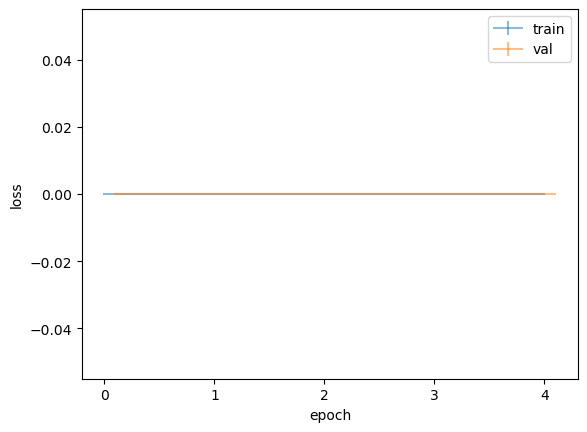

In [232]:
cnn.plot_epochs(box['epochs'])

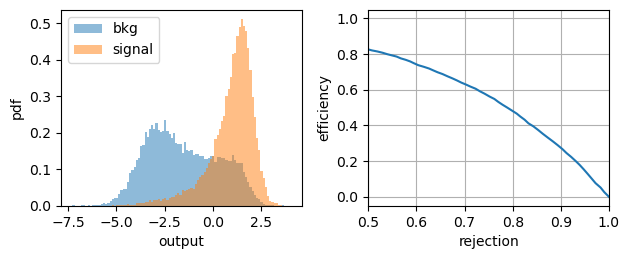

In [233]:
cnn.plot_roc(box['y'], box['yp'])

index  10 target  1 , id 120 386
length  14 , sum  1.0 , mean  0.07142857142857142 , std 0.041743164229358344


(120, 386)

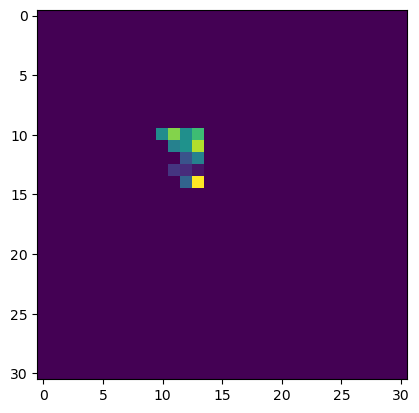

In [82]:
dset0 = cc[0][0]
dset1 = cc[1][0]
    
index = 10
plot_dset(dset0, index)


target  [1.]


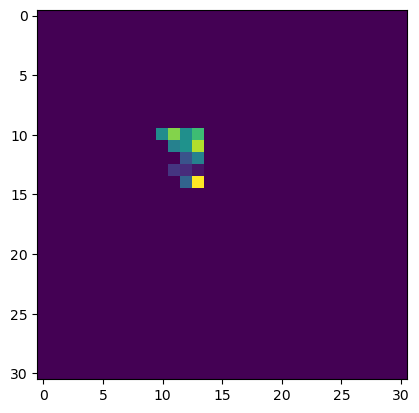

In [72]:
xi, yi = dset0[index]
print('target ', yi.numpy())
plt.imshow(xi.numpy()[0])

index  0 target  [0] , id [[720]
 [  9]]
length  29 , sum  1.0 , mean  0.034482758620689655 , std 0.03480857125396073
index  0 target  0 , id [1922    5]
length  41 , sum  0.9209129763370794 , mean  0.022461292105782422 , std 0.021997425075316827


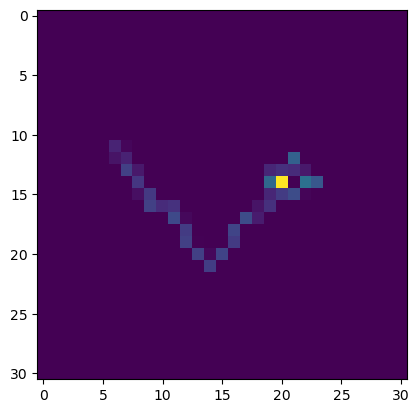

In [55]:
dset0 = cc[0][0]
dset1 = cc[1][0]
    
ievt = 0
plot_dset(dset0, ievt)
plot_dset(dset1, ievt)


In [7]:
ifile2 = ipath + 'shots/' + '5bar_shuffle_s0mm_w10mm.npz'
idata2 = dp.godata_load(ifile2)

y   0
id  [703  20]


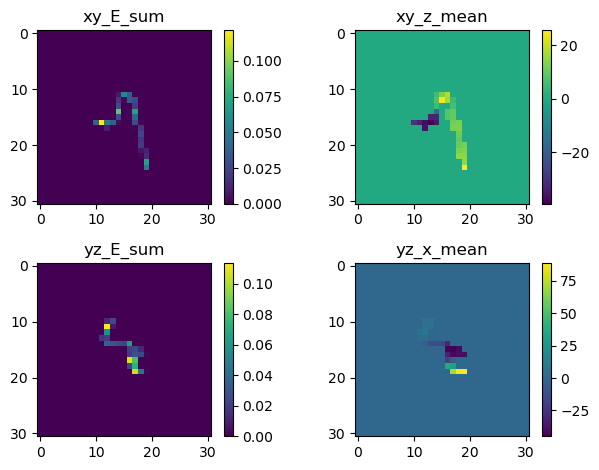

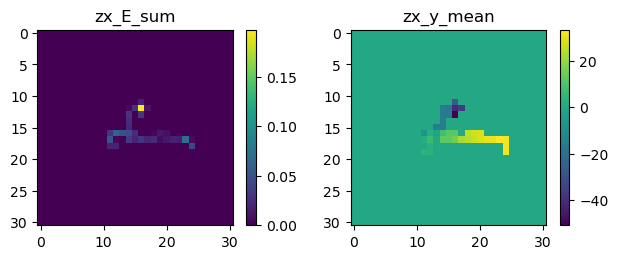

<Figure size 640x480 with 0 Axes>

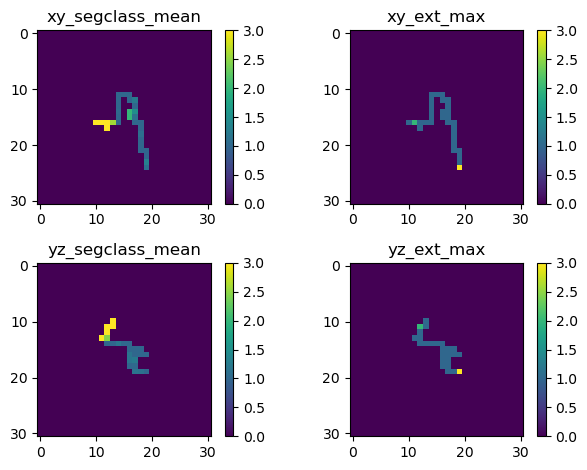

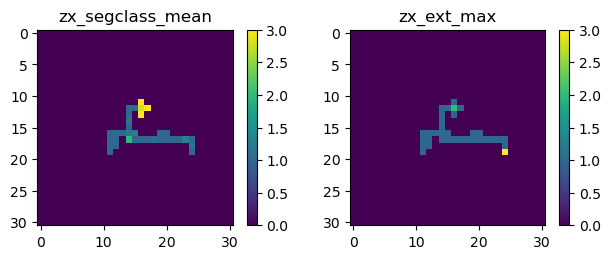

<Figure size 640x480 with 0 Axes>

In [21]:
dp.plot_godata(idata2, 0)

In [2]:
maska = (idata1.y == 1)

NameError: name 'idata1' is not defined

In [17]:
idata2.id[60]

array([172,  58])

In [25]:
m, n = 2, 10
k, f = 4, 2

mycc = cnn.ExtGoCNN(m, n, k, f)

 Conv  : [ 2 ,  10 ] -> [ 4 ,  7 ], ndim =  196 , k =  4
 Conv  : [ 4 ,  7 ] -> [ 8 ,  4 ], ndim =  128 , k =  4
 Conv  : [ 8 ,  4 ] -> [ 16 ,  3 ], ndim =  144 , k =  2
 Conv  : [ 16 ,  3 ] -> [ 32 ,  2 ], ndim =  128 , k =  2
 Lin   :  128  ->  4
 Lin   :  4  ->  1


## Ana CNN

In [26]:
#path       = os.environ['LPRDATADIR']
#ipath      = path + 'xymm/'
#opath      = path + 'cnn/'
#pressure   = '5bar'
projection = ('x', 'y')
#widths     = (10, 10)
#labels     = ['seg',]

idata, odata = cnn.retrieve_cnn_data(ipath, opath, pressure, projection, widths, labels, cnn_name = cnn_name)

data file :  /scratch/next/data/NEXT100/pressure_topology/xymm/xymm_13bar_xy_10x10_100.npz
cnn file  : temp//temp_cnn_esum_xymm_13bar_xy_10x10_100.npz


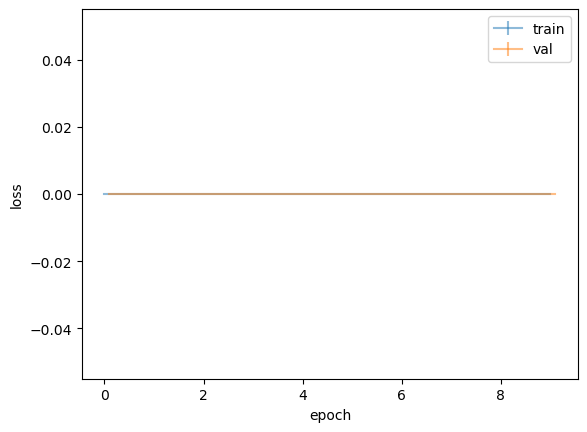

In [27]:
cnn.plot_epochs(odata['epochs'])

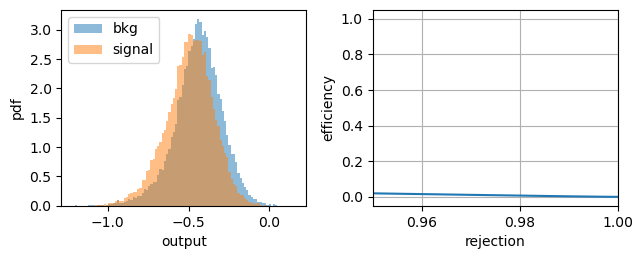

In [28]:
cnn.plot_roc(odata['y'], odata['yp'], 0.95)

event  154094
target test       1
target test pred  0.9983534216880798
success           True
total     test 1.0


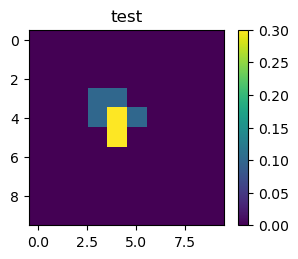

In [22]:
cnn.plot_event(idata, odata, labels)